# Q.2 Implement a neural network for m-samples, n-features as we discussed in class (both FP and BP) and for N layers in the hidden layer. Split the data (you can use the log. reg. data or any other one) and train your network with 70% of the data. Use 15% for validation  and test your network with the remaining 15% data. Report the evaluation metrics for varying number of layers in the network. Plot the training loss curves.


## Load data

In [1]:
import pandas as pd

# Load data
df = pd.read_csv('Logistic_regression_ls.csv')

# Split data into features and labels
X = df[['x1', 'x2']].values
y = df['label'].values.reshape(-1, 1)

# Normalize features
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Split data into train = 70%, validation=15%, and test= remaining 15% 
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]


In [2]:
import numpy as np

# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivative of the sigmoid function
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Mean squared error loss function
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Derivative of mean squared error loss function
def mse_loss_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / len(y_true)


## Define Nueral Network

In [25]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_layers, output_size):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.weights = []
        self.biases = []
        self.activations = []
        self.Z_values = []
        self.train_losses = []
        self.val_losses = []

        layers = [input_size] + hidden_layers + [output_size]

        # Initialize weights and biases randomly
        for i in range(len(layers) - 1):
            self.weights.append(np.random.randn(layers[i], layers[i+1])) # Order of weight matrix will depend on the size of hidden layer
            self.biases.append(np.random.randn(layers[i+1]))

    def forward_propagation(self, X):
        self.activations = []
        self.Z_values = []
        self.activations.append(X)

        for i in range(len(self.weights)):
            # Compute the weighted sum of inputs and add bias
            Z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.Z_values.append(Z)
            # Apply activation function (sigmoid)
            A_values = sigmoid(Z)
            self.activations.append(A_values)

        return self.activations[-1]

    def backward_propagation(self, X, y, learning_rate):
        m = X.shape[0]
        deltas = [self.activations[-1] - y]

        for i in range(len(self.weights) - 1, -1, -1):
            # Calculate gradients
            dW = np.dot(self.activations[i].T, deltas[-1]) / m
            db = np.sum(deltas[-1], axis=0, keepdims=True) / m

            # Update deltas for next layer
            if i > 0:
                delta = np.dot(deltas[-1], self.weights[i].T) * sigmoid_derivative(self.activations[i])
                deltas.append(delta)

            # Update weights and biases
            self.weights[i] -= learning_rate * dW
            self.biases[i] -= learning_rate * db[0]

    def train(self, X_train, y_train, X_val, y_val, epochs, learning_rate):
        for epoch in range(epochs):
            # Forward propagation
            output = self.forward_propagation(X_train)
            
            # Backward propagation
            self.backward_propagation(X_train, y_train, learning_rate)
            
            # Validation loss
            val_output = self.forward_propagation(X_val)
            train_loss = mse_loss(y_train, output)
            val_loss = mse_loss(y_val, val_output)
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            
            # Print progress
            if epoch % 500 == 0:
                print(f"Epoch {epoch}: Train Loss {train_loss}, Validation Loss {val_loss}")
        print('\n')

    def predict(self, X):
        return self.forward_propagation(X)


### Example

In [26]:
# Define neural network parameters
input_size = X.shape[1]
hidden_layers = [5, 5]  # Number of neurons in each hidden layer
output_size = 1

# Initialize and train neural network
nn = NeuralNetwork(input_size, hidden_layers, output_size)
nn.train(X_train, y_train, X_val, y_val, epochs=1000, learning_rate=0.01)

# Evaluate on test set
test_output = nn.predict(X_test)
test_loss = mse_loss(y_test, test_output)
print(f"Test Loss: {test_loss}")

Epoch 0: Train Loss 0.4345945845156334, Validation Loss 0.45284715287368726
Epoch 500: Train Loss 0.2040227854372121, Validation Loss 0.20175940011630303


Test Loss: 0.11999852754793575


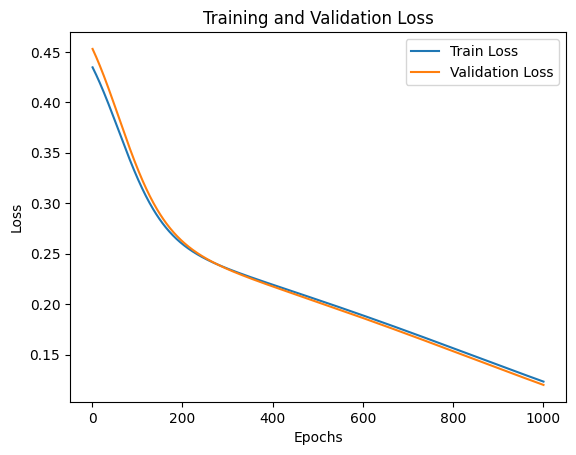

In [27]:
import matplotlib.pyplot as plt

# Plot train and validation loss curves
epochs = range(1, len(nn.train_losses) + 1)
plt.plot(epochs, nn.train_losses, label='Train Loss')
plt.plot(epochs, nn.val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluation matrix and Plots of the train and val Loss when hidden layers = 2, 3, 4, 5

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_network(X_train, y_train, X_val, y_val, X_test, y_test, hidden_layers_list):
    evaluation_results = []

    for hidden_layers in hidden_layers_list:
        # Initialize neural network
        print('Hidden Layers:', hidden_layers)
        nn = NeuralNetwork(input_size, hidden_layers, output_size)
        
        # Train neural network
        nn.train(X_train, y_train, X_val, y_val, epochs=1000, learning_rate=0.01)
        
        # Evaluate on test set
        test_output = nn.predict(X_test)
        test_loss = mse_loss(y_test, test_output)
        
        # Calculate additional evaluation metrics
        y_pred = np.round(test_output)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Store evaluation metrics and loss curves
        evaluation_results.append({
            'Hidden Layers': hidden_layers,
            'Test Loss': test_loss,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1,
            'Train Loss': nn.train_losses,
            'Val Loss': nn.val_losses
        })

    return evaluation_results

## For 2 hidden layers

In [29]:
# Define list of hidden layers to evaluate
hidden_layers_list = [[5, 5], [10, 10], [15, 15]]

# Evaluate the network for different numbers of hidden layers
evaluation_results = evaluate_network(X_train, y_train, X_val, y_val, X_test, y_test, hidden_layers_list)

# Print evaluation metrics
for result in evaluation_results:
    hidden_layers_str = '-'.join(str(layer) for layer in result['Hidden Layers'])
    print(f"Evaluation Metrics for Hidden Layers: {hidden_layers_str}")
    print(f"Test Loss: {result['Test Loss']}")
    print(f"Accuracy: {result['Accuracy']}")
    print(f"Precision: {result['Precision']}")
    print(f"Recall: {result['Recall']}")
    print(f"F1-score: {result['F1-score']}")
    print()

Hidden Layers: [5, 5]
Epoch 0: Train Loss 0.4465454854928318, Validation Loss 0.46513337530122917
Epoch 500: Train Loss 0.1446684027393521, Validation Loss 0.14302012877924034


Hidden Layers: [10, 10]
Epoch 0: Train Loss 0.31116974207144554, Validation Loss 0.31560310538263464
Epoch 500: Train Loss 0.17351109746709742, Validation Loss 0.17077067898985143


Hidden Layers: [15, 15]
Epoch 0: Train Loss 0.4774189076100522, Validation Loss 0.498133364201441
Epoch 500: Train Loss 0.09098987532436156, Validation Loss 0.09057657220796703


Evaluation Metrics for Hidden Layers: 5-5
Test Loss: 0.07296845475312388
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Evaluation Metrics for Hidden Layers: 10-10
Test Loss: 0.08169418609672625
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Evaluation Metrics for Hidden Layers: 15-15
Test Loss: 0.022389254446993172
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0



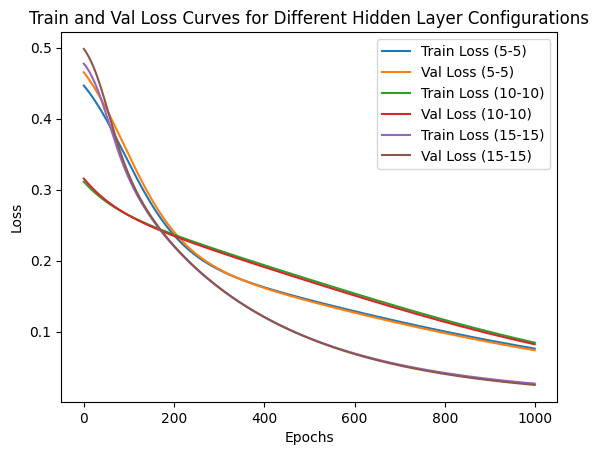

In [30]:
# Plot train and validation loss curves for each configuration of hidden layers
for result in evaluation_results:
    hidden_layers_str = '-'.join(str(layer) for layer in result['Hidden Layers'])
    plt.plot(range(len(result['Train Loss'])), result['Train Loss'], label=f'Train Loss ({hidden_layers_str})')
    plt.plot(range(len(result['Val Loss'])), result['Val Loss'], label=f'Val Loss ({hidden_layers_str})')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Val Loss Curves for Different Hidden Layer Configurations')
plt.legend()
plt.show()

## For 3 hidden layers

In [31]:
# No of neurons in each layer

hidden_layers_list = [[5, 5, 10], [5, 10, 10], [10, 15, 15]]

# Evaluate the network for different numbers of hidden layers
evaluation_results = evaluate_network(X_train, y_train, X_val, y_val, X_test, y_test, hidden_layers_list)

# Print evaluation metrics
for result in evaluation_results:
    hidden_layers_str = '-'.join(str(layer) for layer in result['Hidden Layers'])
    print(f"Evaluation Metrics for Hidden Layers: {hidden_layers_str}")
    print(f"Test Loss: {result['Test Loss']}")
    print(f"Accuracy: {result['Accuracy']}")
    print(f"Precision: {result['Precision']}")
    print(f"Recall: {result['Recall']}")
    print(f"F1-score: {result['F1-score']}")
    print()

Hidden Layers: [5, 5, 10]
Epoch 0: Train Loss 0.2969728497595731, Validation Loss 0.30399422904965184
Epoch 500: Train Loss 0.23553340261564895, Validation Loss 0.2352530191645837


Hidden Layers: [5, 10, 10]
Epoch 0: Train Loss 0.3541466016330924, Validation Loss 0.36754010586233393
Epoch 500: Train Loss 0.23274997252763613, Validation Loss 0.2343498907082216


Hidden Layers: [10, 15, 15]
Epoch 0: Train Loss 0.2588098651288757, Validation Loss 0.25887463836753893
Epoch 500: Train Loss 0.17571481445635118, Validation Loss 0.17738792367442696


Evaluation Metrics for Hidden Layers: 5-5-10
Test Loss: 0.19485572748236998
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Evaluation Metrics for Hidden Layers: 5-10-10
Test Loss: 0.208863477250758
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Evaluation Metrics for Hidden Layers: 10-15-15
Test Loss: 0.08508321469352824
Accuracy: 0.9866666666666667
Precision: 0.9736842105263158
Recall: 1.0
F1-score: 0.9866666666666667



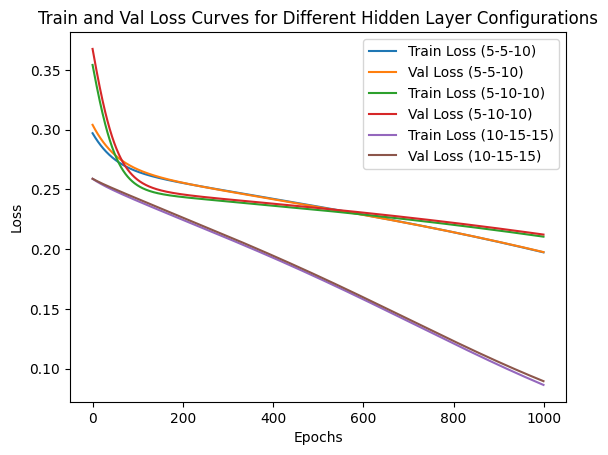

In [32]:
# Plot train and validation loss curves for each configuration of hidden layers
for result in evaluation_results:
    hidden_layers_str = '-'.join(str(layer) for layer in result['Hidden Layers'])
    plt.plot(range(len(result['Train Loss'])), result['Train Loss'], label=f'Train Loss ({hidden_layers_str})')
    plt.plot(range(len(result['Val Loss'])), result['Val Loss'], label=f'Val Loss ({hidden_layers_str})')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Val Loss Curves for Different Hidden Layer Configurations')
plt.legend()
plt.show()

## For 4 hidden layers

In [33]:
hidden_layers_list = [[5, 5, 10, 5], [5, 10, 15, 10], [10, 10, 15, 15]]

# Evaluate the network for different numbers of hidden layers
evaluation_results = evaluate_network(X_train, y_train, X_val, y_val, X_test, y_test, hidden_layers_list)

# Print evaluation metrics
for result in evaluation_results:
    hidden_layers_str = '-'.join(str(layer) for layer in result['Hidden Layers'])
    print(f"Evaluation Metrics for Hidden Layers: {hidden_layers_str}")
    print(f"Test Loss: {result['Test Loss']}")
    print(f"Accuracy: {result['Accuracy']}")
    print(f"Precision: {result['Precision']}")
    print(f"Recall: {result['Recall']}")
    print(f"F1-score: {result['F1-score']}")
    print()

Hidden Layers: [5, 5, 10, 5]
Epoch 0: Train Loss 0.33115963612589644, Validation Loss 0.343078485808432
Epoch 500: Train Loss 0.24602044690166805, Validation Loss 0.24652314763126398


Hidden Layers: [5, 10, 15, 10]
Epoch 0: Train Loss 0.4500731255378207, Validation Loss 0.42839642604907235
Epoch 500: Train Loss 0.2362833969481233, Validation Loss 0.23686378341090883


Hidden Layers: [10, 10, 15, 15]
Epoch 0: Train Loss 0.48242729921085914, Validation Loss 0.4594588828836484
Epoch 500: Train Loss 0.1744682579087482, Validation Loss 0.17497056376262612


Evaluation Metrics for Hidden Layers: 5-5-10-5
Test Loss: 0.2387295474151051
Accuracy: 0.9866666666666667
Precision: 1.0
Recall: 0.972972972972973
F1-score: 0.9863013698630136

Evaluation Metrics for Hidden Layers: 5-10-15-10
Test Loss: 0.22437248063825385
Accuracy: 0.9866666666666667
Precision: 1.0
Recall: 0.972972972972973
F1-score: 0.9863013698630136

Evaluation Metrics for Hidden Layers: 10-10-15-15
Test Loss: 0.07921320028146228
Ac

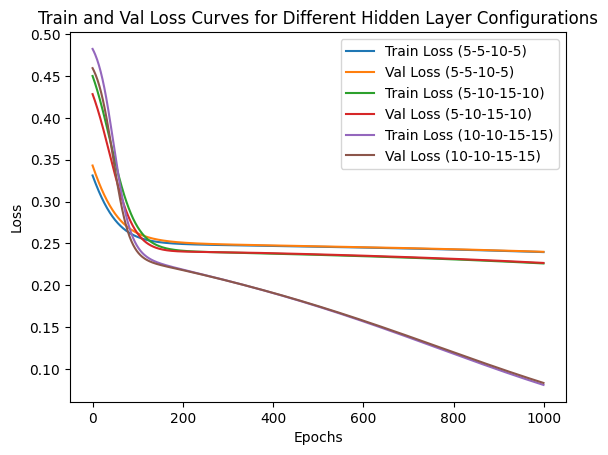

In [34]:
# Plot train and validation loss curves for each configuration of hidden layers
for result in evaluation_results:
    hidden_layers_str = '-'.join(str(layer) for layer in result['Hidden Layers'])
    plt.plot(range(len(result['Train Loss'])), result['Train Loss'], label=f'Train Loss ({hidden_layers_str})')
    plt.plot(range(len(result['Val Loss'])), result['Val Loss'], label=f'Val Loss ({hidden_layers_str})')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Val Loss Curves for Different Hidden Layer Configurations')
plt.legend()
plt.show()

## For 5 hidden layers

In [37]:
hidden_layers_list = [[5, 5, 5, 5, 5], [10, 10, 10, 10, 10], [15, 15, 15, 15, 15]]

# Evaluate the network for different numbers of hidden layers
evaluation_results = evaluate_network(X_train, y_train, X_val, y_val, X_test, y_test, hidden_layers_list)

# Print evaluation metrics
for result in evaluation_results:
    hidden_layers_str = '-'.join(str(layer) for layer in result['Hidden Layers'])
    print(f"Evaluation Metrics for Hidden Layers: {hidden_layers_str}")
    print(f"Test Loss: {result['Test Loss']}")
    print(f"Accuracy: {result['Accuracy']}")
    print(f"Precision: {result['Precision']}")
    print(f"Recall: {result['Recall']}")
    print(f"F1-score: {result['F1-score']}")
    print()

Hidden Layers: [5, 5, 5, 5, 5]
Epoch 0: Train Loss 0.29656541213441423, Validation Loss 0.285704770260025
Epoch 500: Train Loss 0.24449513512394652, Validation Loss 0.24441753786482825


Hidden Layers: [10, 10, 10, 10, 10]
Epoch 0: Train Loss 0.3228066726718507, Validation Loss 0.309093124893642
Epoch 500: Train Loss 0.24655789003765952, Validation Loss 0.24689581079639486


Hidden Layers: [15, 15, 15, 15, 15]
Epoch 0: Train Loss 0.3896019179690755, Validation Loss 0.3701714741498659
Epoch 500: Train Loss 0.2489966022921701, Validation Loss 0.24908565298078889


Evaluation Metrics for Hidden Layers: 5-5-5-5-5
Test Loss: 0.24303328702811208
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Evaluation Metrics for Hidden Layers: 10-10-10-10-10
Test Loss: 0.2391298055850315
Accuracy: 0.9866666666666667
Precision: 1.0
Recall: 0.972972972972973
F1-score: 0.9863013698630136

Evaluation Metrics for Hidden Layers: 15-15-15-15-15
Test Loss: 0.23244510792280834
Accuracy: 1.0
Precision: 1.0


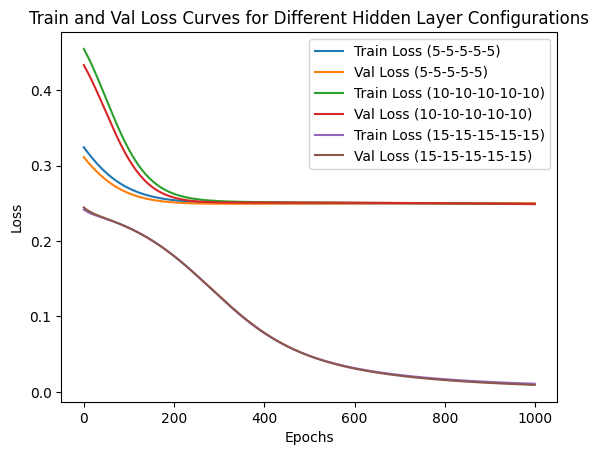

In [36]:
# Plot train and validation loss curves for each configuration of hidden layers
for result in evaluation_results:
    hidden_layers_str = '-'.join(str(layer) for layer in result['Hidden Layers'])
    plt.plot(range(len(result['Train Loss'])), result['Train Loss'], label=f'Train Loss ({hidden_layers_str})')
    plt.plot(range(len(result['Val Loss'])), result['Val Loss'], label=f'Val Loss ({hidden_layers_str})')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Val Loss Curves for Different Hidden Layer Configurations')
plt.legend()
plt.show()